### Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación

### Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones 2022
Búsqueda y Recomendación para Textos Legales

Mentor: Jorge E. Pérez Villella

# Práctico Análisis y Visualización

Integrantes:
* Fernando Agustin Cardellino
* Adrian Zelaya


### Objetivos:

* Generar un corpus con todos los documentos. 

* Dividir el corpus en tokens, graficar el histograma de frecuencia de palabras demostrando la ley Zipf. 

* Analizar palabras más frecuentes y menos frecuentes. Seleccionar 5 documentos de cada fuero y realizar el mismo análisis. ¿Se repiten las palabras? 

* Hacer lo mismo con n-gramas.

* Visualizar la frecuencia de palabras en una nube de palabras.

* Elaborar una breve conclusión de lo encontrado

Fecha de Entrega: 20 de mayo de 2022

In [28]:
# Importamos las librerías necesarias

import numpy as np
import pandas as pd
import os
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from nltk.corpus import stopwords

#import nltk
#nltk.download('stopwords')  # Descomentar para bajar las stopwords

In [29]:
# Cargamos modelo de spacy y stopwords de NLTK
nlp = spacy.load("es_core_news_sm")

CURR_DIR = os.getcwd()  # Gets current directory
STOPWORDS_ES = stopwords.words('spanish')
BREAKPOINT=None  # None para analizar todos los documentos, sino un número para analizar hasta n documentos
img_name = "legal-icon-png"

### Funciones que vamos a utilizar en el Práctico

##### Funciones auxiliares

In [30]:
def getListOfFiles(dirName, return_dir=False):
    # create a list of file and sub directories
    # names in the given directory
    files = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for file in files:
        # Create full path
        fullPath = os.path.join(dirName, file)
        # If entry is a directory then get the list of files in this directory
        if os.path.isdir(fullPath):
            if return_dir:
                allFiles.append(fullPath.split(os.sep)[-1])
            else:
                allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)

    return allFiles


def save_to_pickle(obj, filename):
    """
    TODO: [E111] Pickling a token is not supported, because tokens are only views of the parent Doc and can't exist on
    their own. A pickled token would always have to include its Doc and Vocab, which has practically no advantage over
    pickling the parent Doc directly. So instead of pickling the token, pickle the Doc it belongs to.
    :param obj:
    :param filename:
    :return:
    """

    file_path = f"{CURR_DIR}\\{filename}"
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, 'rb') as output:
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)


def series_to_dataframe(series, column_names=None):
    col_names = [series.name, 'values'] if column_names is None else column_names
    return pd.DataFrame([series.index, series.values], columns=col_names)


##### Funciones específicas del análisis

In [31]:
def get_palabras(files_path, fuero_name=None, ngrams=False, breakpoint=None):
    """
    Función que arma el corpus de palabras y las tokeniza, utilizando SpaCy.
    Si Breakpoint != None, dar el número de docs con el que se interrumpe la función
    """
    corpus = {}

    corpus_list = []

    palabras = []

    i = 0
    for filename in getListOfFiles(files_path):
        file_name = filename.split(os.sep)[-1]
        fuero = fuero_name if fuero_name is not None else filename.split(os.sep)[-2]
        if fuero not in corpus.keys():
            corpus[fuero] = {}

        # Creamos este diccionario para luego utilizarlo para armar un dataframe
        corpus_dict = {'fuero': fuero,
                       'documento': file_name}

        with open(filename, encoding='utf-8') as file:
            file_text = file.read()

            nlp_doc = nlp(file_text)
            corpus[fuero][file_name] = nlp_doc
            corpus_dict['texto'] = nlp_doc
            corpus_list.append(corpus_dict)
            if ngrams:
                nlp_doc = nlp_doc.noun_chunks
            for token in nlp_doc:
                if ngrams:
                    palabras.append(token)
                elif token.is_alpha:  # si es sólo alfabético
                    palabras.append(token)
        # remover esta sección (testing)
        if breakpoint:
            i += 1
            if i > breakpoint:
                break
    return palabras, corpus


def get_conteo_palabras(palabras):
    """Función que genera un pandas DataFrame con la frecuencia de las palabras
    """
    palabras_df = pd.DataFrame([{'palabra': str(x).lower()} for x in palabras])
    # print(corpus_df.head())

    return palabras_df.groupby(['palabra'])['palabra'].count().sort_values(ascending=False)


def show_histogram(dataframe, threshold=1):
    """Función que plotea un histograma
    """
    dataframe[dataframe > threshold].plot(kind='bar')
    plt.show()


def plot_create_subplots(n_subplots, sup_title, n_rows = 5, share_x=False, fig_size=(16, 16)):
    sns.set(style="darkgrid")
    n_ratio = int(n_subplots/n_rows) 
    n_cols = n_ratio if n_subplots % n_rows == 0 else n_ratio + 1
    fig, axes = plt.subplots(n_rows, n_cols, sharex=share_x, figsize=fig_size)
    fig.suptitle(sup_title)
    return fig, axes
    
    
def plot_histogram(dataframe, threshold=1, y_low=None, description=None):

    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    plt.figure(figsize=(20, 8), dpi=80)
    
    x=dataframe[:threshold].index 
    y=dataframe[:threshold].values
    
    y_cutoff = dataframe[:threshold].quantile(0.8) if y_low is None else y_low
    
    my_color = np.where(y>=y_cutoff, 'orange', 'skyblue')
    
    # The vertical plot is made using the vline function
    plt.vlines(x=x, ymin=0, ymax=y, color=my_color, alpha=0.4, linewidth=3.5)
    plt.scatter(x, y, color=my_color, s=25, alpha=1)

    # Add title and axis names
    identifier = '' if description is None else f" ({description})"
    
    plt.title(f"Distribución de Frecuencia de Palabras{identifier}", loc='center')
    plt.xlabel('Palabra')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation = 45)
    
    # Formateamos los valores del eje-y
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

    # Show the graph
    plt.show()
    
def show_zipf(dataframe, description=None):
    """Función que grafica la Ley de Zipf (scatterplot con ejes en escala logarítmica)
    """
    sns.set(style="darkgrid")
    
    rank_palabras = [x + 1 for x in range(len(dataframe))]
    
    sns.scatterplot(x=rank_palabras,
                    y=dataframe).set(xscale="log",
                                     yscale="log",
                                     ylabel='log(Frecuencia)',
                                     xlabel='log(Orden)')
    
    identifier = '' if description is None else f" ({description})"
    plt.title(f"Ley de Zipf{identifier}", loc='center')
    
    plt.show()
    
    
def comparar_frecuencias_palabras(dataframe, max_palabras=50 ,description=None):
    """Función que compara entre las palabras más y menos frecuentes 
    """
    if description:
        print(description)
    print(
        f"\nLas {max_palabras} palabras más frecuentes son:\n{dataframe.head(max_palabras)}"
    )# La mayoría son todas stopwords, a partir de la 20ma empiezan a haber palabras propias del ámbito jurídico
    
    print(f"\nLas {max_palabras} palabras menos frecuentes son:\n{dataframe.tail(max_palabras)}"
    )  # palabras normales pero donde la mayoría comparte una base en común (e.g. ordenadas, ordenado, ordenando) >> con lematización, se podría disminuir esto
    
    return dataframe.head(max_palabras).index.values


def get_n_grams(tokens, n):
    """Función que genera n-gramas en base a una lista de tokens de SpaCy
    """
    return [' '.join([token.text for token in tokens[i:i+n]]) for i in range(len(tokens) - n + 1)]


def generar_wordcloud(img_name, stopwords, tokens, output_path):
    """Función que genera una nube de palabras (wordcloud) sobre una imagen de fondo.    
    """
    
    image_name = os.path.join("img",f"{img_name}.jpg")

    
    # Generate a word cloud image
    mask = np.array(Image.open(image_name))
    text = ' '.join(
        [token.text for token in tokens])
    wordcloud_law = WordCloud(
        #stopwords=stopwords,
        background_color="white", 
        mode="RGBA",
        max_words=1000,
        mask=mask).generate(text)
    
    # create coloring from image
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=[7, 7])
    plt.imshow(wordcloud_law.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    
    # store to file
    plt.savefig(output_path, format="png")
    
    plt.show()

### Análisis de los documentos







#### Generar un corpus con todos los documentos

In [32]:
# Ubicación de los documentos
filesDir = os.path.join(CURR_DIR, "Documentos")

# Obtenemos lista de los fueros
fueros = getListOfFiles(filesDir, return_dir=True)

In [33]:
# Generamos el corpus de palabras, y el diccionario con el mapeo de los fueros con sus respectivos documentos
palabras, corpus_dic = get_palabras(filesDir, breakpoint=BREAKPOINT)

frecuencia_palabras_df = get_conteo_palabras(palabras)

print(frecuencia_palabras_df)

palabra
de              82652
la              58564
que             41759
el              35420
en              33322
                ...  
misóginos           1
cargoso             1
mitigar             1
mitos               1
cumpliéndola        1
Name: palabra, Length: 27508, dtype: int64


#### Análisis de palabras para todos los docs

##### Ley de Zipf
Analizamos las frecuencias de las palabras para determinar si se verifica la ley de Zipf.
El primer gráfico corresponde a la distribución de las palabras que se repiten al menos 50 veces.
En el segundo gráfico se muestran las frecuencias vs el orden de las palabras en escala logarítmica (ambos ejes).
Ambos gráficos confirman un comportamiento exponencial.

/run/user/1000/app/com.jetbrains.PyCharm-Community/ipykernel_334/4102510827.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


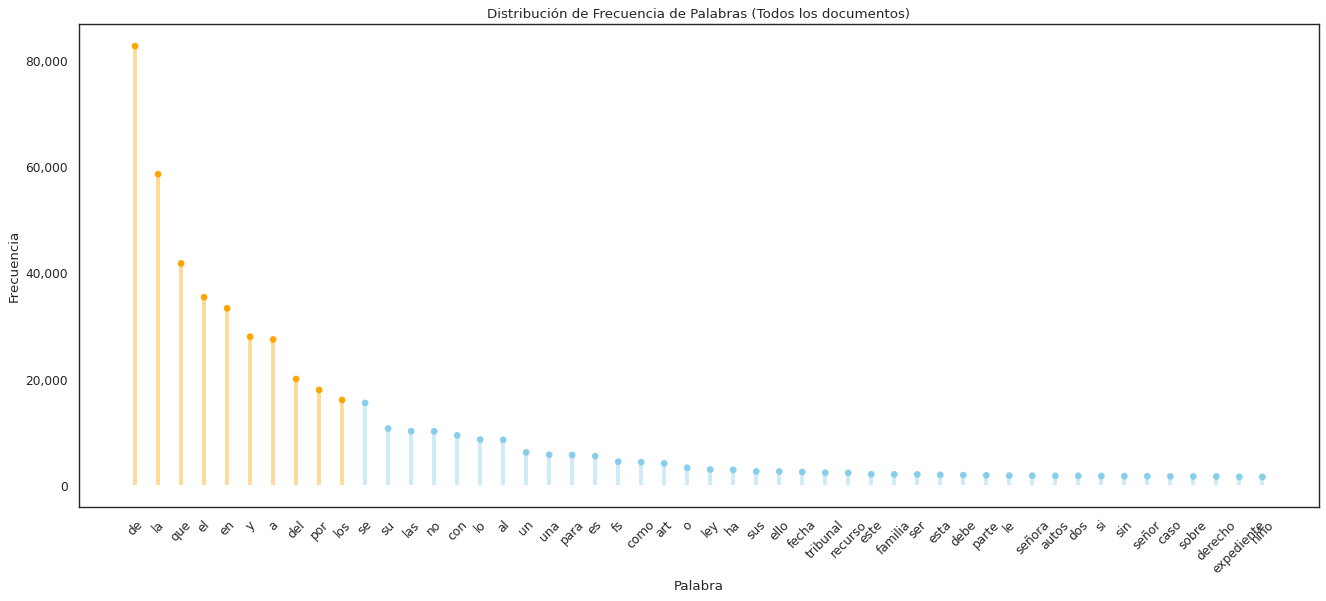

In [34]:
identifier = 'Todos los documentos'

#show_histogram(frecuencia_palabras_df, threshold=1)
plot_histogram(
    frecuencia_palabras_df,
    threshold=50,  # Nos quedamos con las 50 palabras más frecuentes
    y_low=None,
    description=identifier)

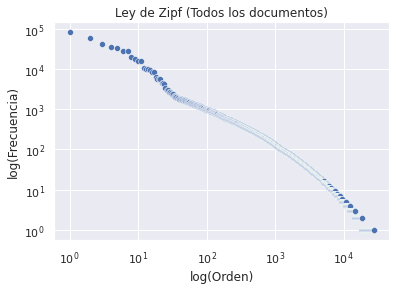

In [35]:
show_zipf(frecuencia_palabras_df, description=identifier)

##### Analizar palabras más frecuentes y menos frecuentes (todos los docs)
Analizar palabras más frecuentes y menos frecuentes.

In [36]:
comparar_frecuencias_palabras(frecuencia_palabras_df, description=identifier)

Todos los documentos

Las 50 palabras más frecuentes son:
palabra
de            82652
la            58564
que           41759
el            35420
en            33322
y             27967
a             27462
del           20029
por           17967
los           16072
se            15525
su            10699
las           10196
no            10167
con            9408
lo             8624
al             8582
un             6218
una            5779
para           5723
es             5513
fs             4463
como           4390
art            4137
o              3326
ley            2995
ha             2940
sus            2626
ello           2614
fecha          2515
tribunal       2391
recurso        2371
este           2090
familia        2084
ser            2064
esta           1991
debe           1946
parte          1897
le             1842
señora         1831
autos          1811
dos            1806
si             1765
sin            1730
señor          1723
caso           1690
sobre         

array(['de', 'la', 'que', 'el', 'en', 'y', 'a', 'del', 'por', 'los', 'se',
       'su', 'las', 'no', 'con', 'lo', 'al', 'un', 'una', 'para', 'es',
       'fs', 'como', 'art', 'o', 'ley', 'ha', 'sus', 'ello', 'fecha',
       'tribunal', 'recurso', 'este', 'familia', 'ser', 'esta', 'debe',
       'parte', 'le', 'señora', 'autos', 'dos', 'si', 'sin', 'señor',
       'caso', 'sobre', 'derecho', 'expediente', 'niño'], dtype=object)

Las palabras más frecuentes son las denominadas "stopwords", como por ejemplo: "de", "la", "que", etc. 
Las palabras menos frecuentes en sí son genéricas, que se pueden encontrar en cualquier contexto, no necesariamente vinculadas al ámbito jurídico/legal. También vemos que hay muchas palabras que corresponden a variaciones de la misma raíz, e.g. allanarse, allanar

##### Visualizar la frecuencia de palabras en una nube de palabras

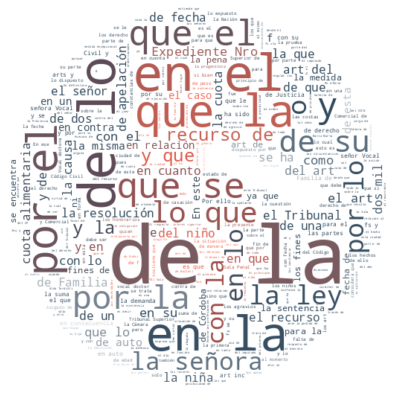

In [37]:
output_name = os.path.join("img",f"{img_name}_wordcloud_ALL.png")

generar_wordcloud(img_name, STOPWORDS_ES, palabras, output_name)

#### Análisis de palabras por fueros

##### Analizar palabras más frecuentes y menos frecuentes (por fueros)
Analizar palabras más frecuentes y menos frecuentes. Seleccionar 5 documentos de cada fuero y realizar el mismo análisis. ¿Se repiten las palabras?

Fuero: Familia

Las 50 palabras más frecuentes son:
palabra
de             39435
la             28160
que            20593
el             17195
en             15132
y              13305
a              12664
del             9255
por             8744
los             8294
se              7766
no              5472
las             4780
su              4703
lo              4570
al              4335
con             4070
fs              3193
es              2879
un              2649
una             2567
para            2554
art             2096
como            1776
ha              1754
recurso         1632
fecha           1624
ley             1525
familia         1433
o               1344
apelación       1300
sus             1268
cuota           1225
señora          1192
alimentaria     1187
debe            1170
ser             1150
ello            1147
parte           1071
autos           1065
señor           1065
tribunal         950
este             941
mil              932
resolución      

/run/user/1000/app/com.jetbrains.PyCharm-Community/ipykernel_334/4102510827.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


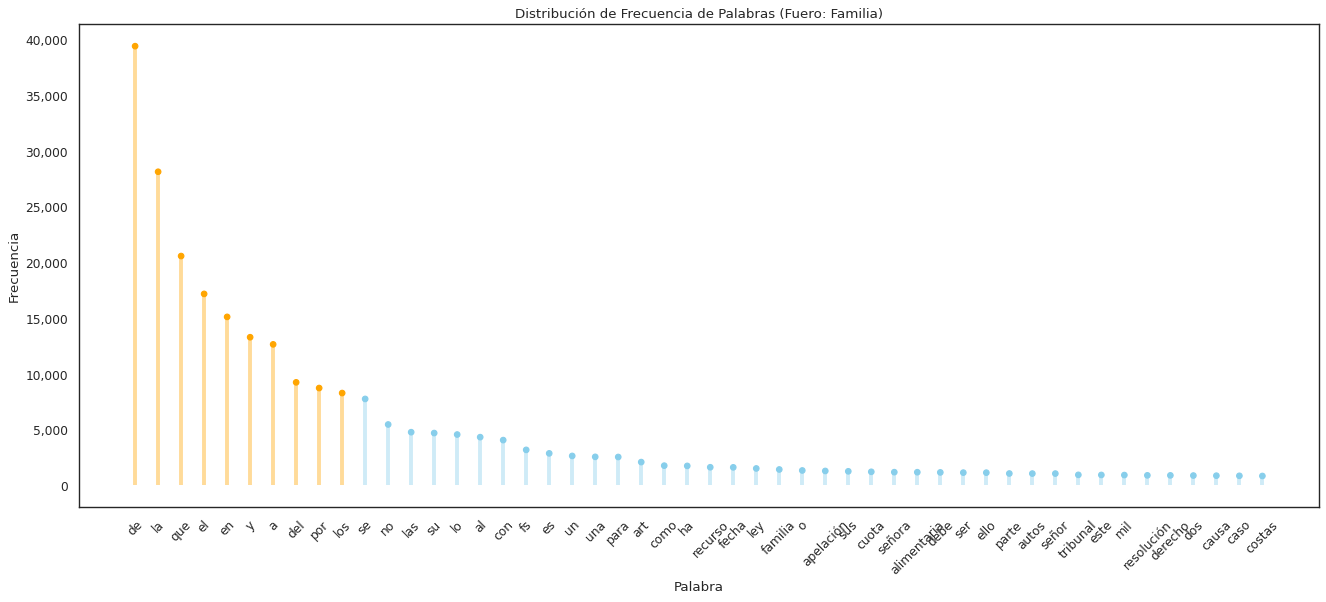

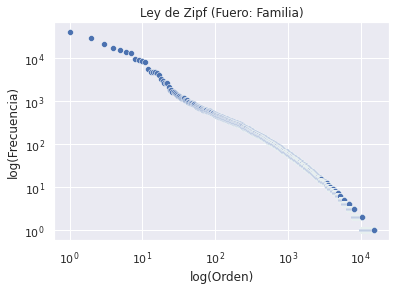

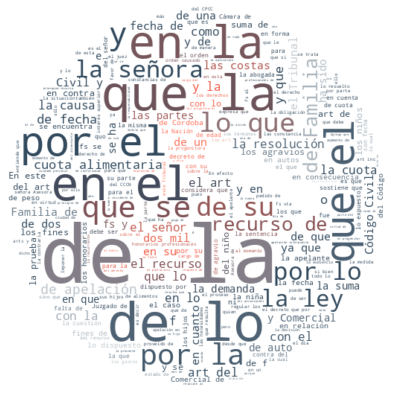

Fuero: Laboral

Las 50 palabras más frecuentes son:
palabra
de            3704
la            3539
el            2150
que           1834
en            1694
a             1662
por           1309
y             1280
del           1099
los            798
se             635
art            508
las            500
con            410
luis           379
al             366
no             347
vocal          344
lo             338
su             322
ley            318
señor          279
expediente     274
un             255
n              239
doctor         236
dijo           236
nro            235
rubio          228
para           219
tribunal       206
es             202
sala           201
blanc          199
angulo         198
me             191
mercedes       191
sentencia      185
e              178
nº             178
enrique        178
recurso        177
arabel         176
eugenio        172
acuerdo        158
laboral        155
fs             151
fecha          151
voto           149
primera  

/run/user/1000/app/com.jetbrains.PyCharm-Community/ipykernel_334/4102510827.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


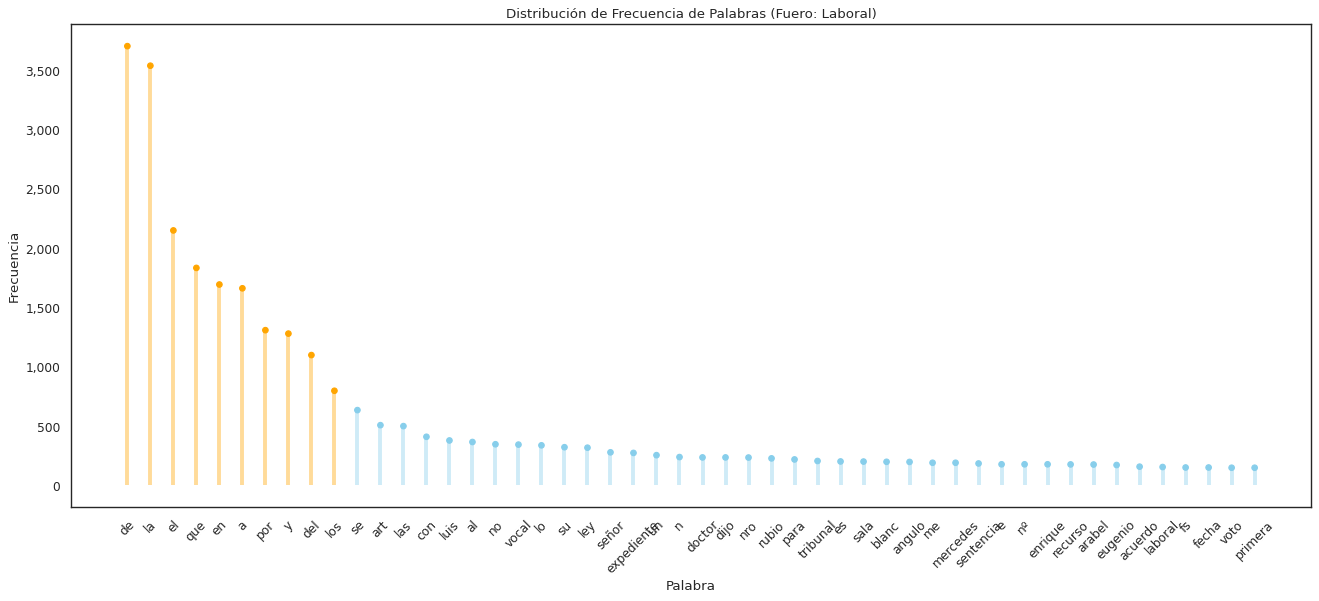

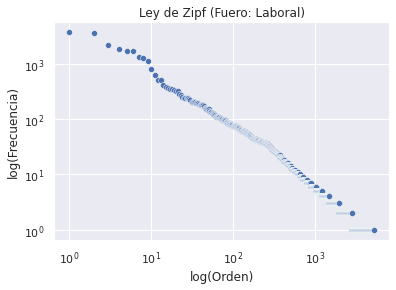

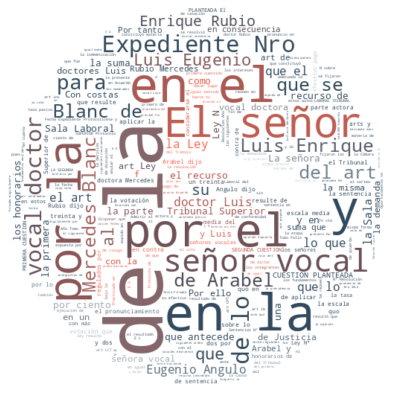

Fuero: Menores

Las 50 palabras más frecuentes son:
palabra
de            13745
la             9222
que            5411
y              5160
a              4925
en             4743
el             4679
del            3028
los            2470
por            2326
su             2299
se             2188
con            1945
las            1410
al             1330
no             1179
lo             1091
fs             1007
un              976
niño            939
una             904
para            880
es              804
como            790
derechos        631
art             629
familia         592
ley             591
o               585
sus             580
niña            542
medida          421
autos           405
familiar        398
situación       390
derecho         378
ser             373
ha              352
relación        342
dos             340
protección      337
fecha           335
le              331
ello            320
este            311
adopción        294
niñez           290


/run/user/1000/app/com.jetbrains.PyCharm-Community/ipykernel_334/4102510827.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


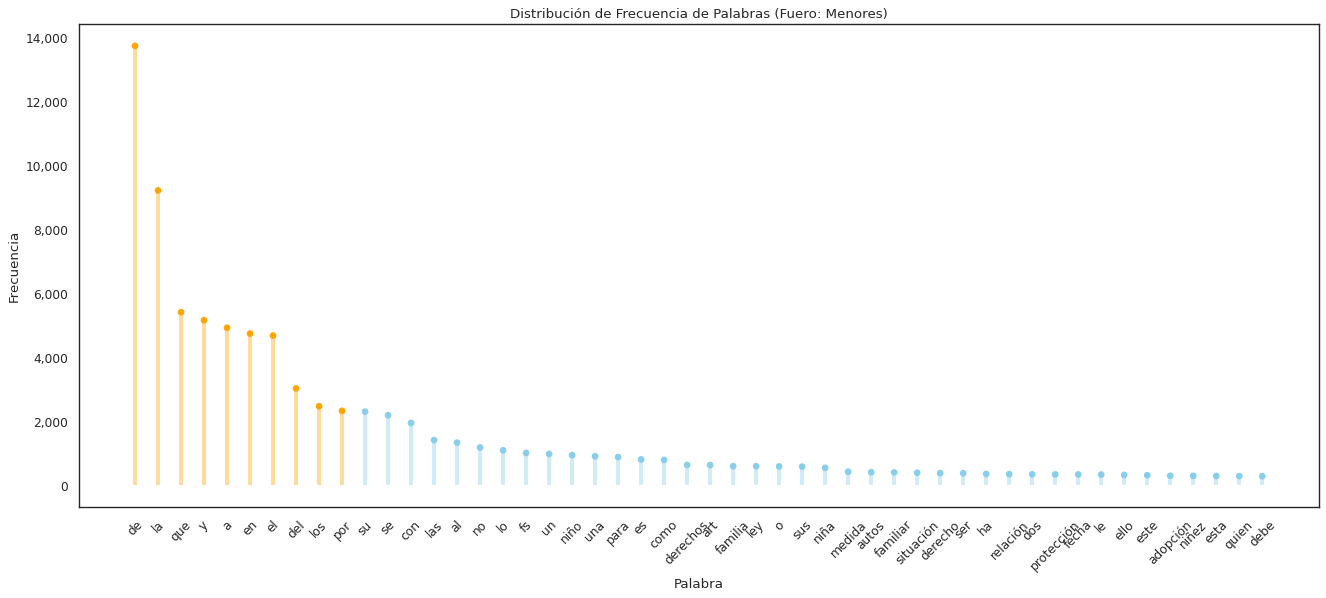

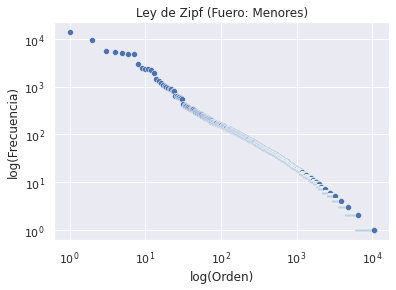

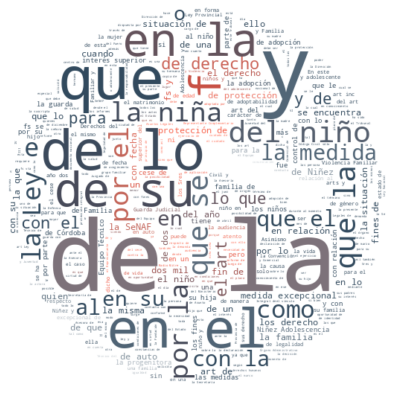

Fuero: Penal

Las 50 palabras más frecuentes son:
palabra
de            25768
la            17643
que           13921
en            11753
el            11396
y              8222
a              8211
del            6647
por            5588
se             4936
los            4510
las            3506
su             3375
no             3169
con            2983
lo             2625
al             2551
un             2338
una            2200
para           2070
como           1716
es             1628
o              1322
penal          1297
expediente     1289
nro            1243
tribunal       1100
ello           1016
esta            941
art             904
pena            904
vocal           834
ha              827
nº              817
este            796
sala            770
le              752
imputado        745
sus             697
así             662
sentencia       642
entre           637
sin             636
ff              629
sobre           621
si              603
hecho           594
ju

/run/user/1000/app/com.jetbrains.PyCharm-Community/ipykernel_334/4102510827.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


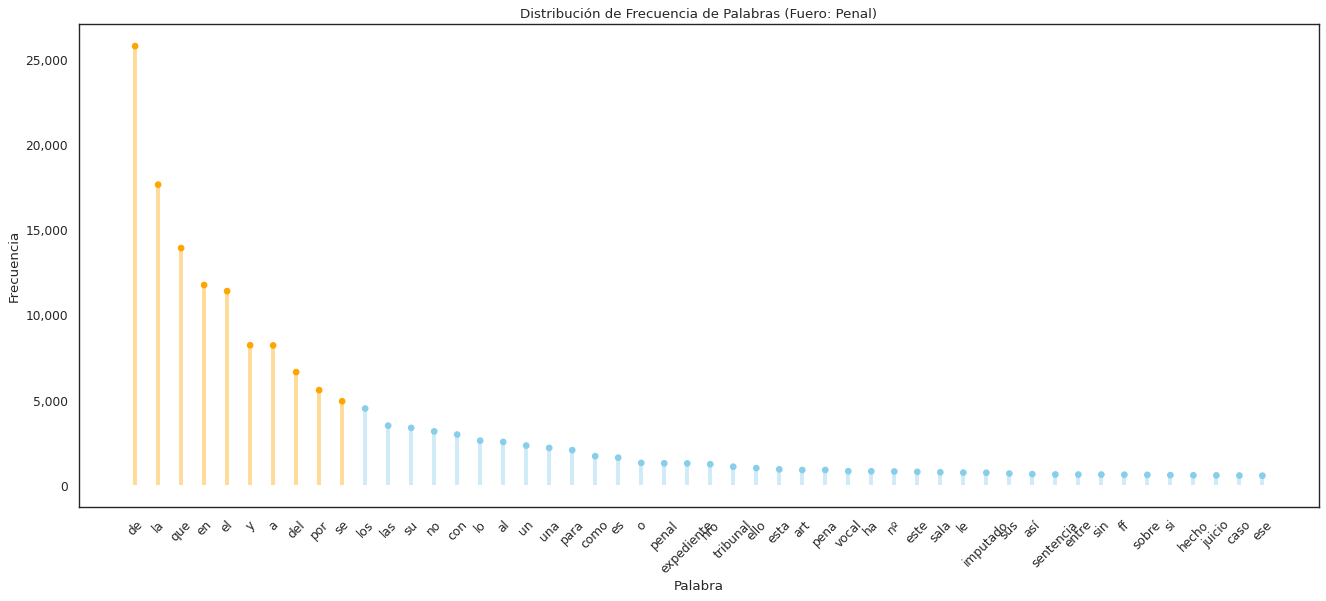

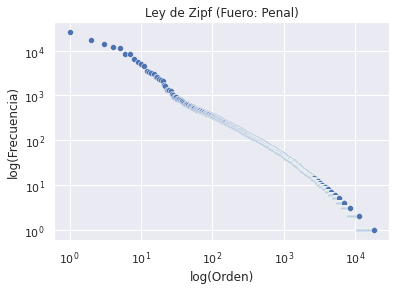

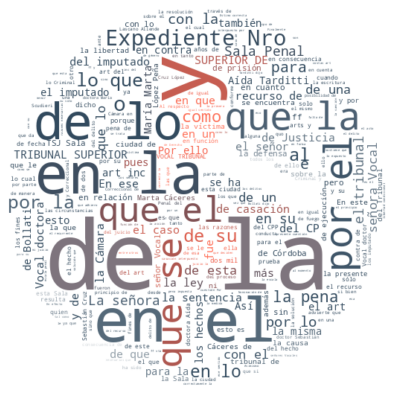


Las palabras que se repiten en todos los fueros son las siguientes: 
{'art', 'lo', 'en', 'un', 'del', 'con', 'que', 'a', 'los', 'al', 'la', 'es', 'para', 'de', 'por', 'no', 'y', 'su', 'las', 'el', 'se'}


In [39]:
# Analizamos por fueros

fueros_lista = []


for fuero in ['FAMILIA', 'LABORAL', 'MENORES', 'PENAL']:
    filesDir = os.path.join(CURR_DIR, "Documentos", fuero)
    identifier = f"Fuero: {fuero.title()}"
    palabras_fuero, corpus_dic_fuero = get_palabras(filesDir, fuero_name=fuero, breakpoint=BREAKPOINT)

    palabras_df = get_conteo_palabras(palabras_fuero)

    # Convertimos las palabras más frecuentes en un conjunto, a modo de poder utilizar la propiedad intersección (de conjuntos)
    fueros_lista.append(
        set(comparar_frecuencias_palabras(palabras_df, description=identifier))
    )
    
    plot_histogram(
        palabras_df,
        threshold=50,  # Nos quedamos con las palabras con una frecuencia > 50
        y_low=None,
        description=identifier)
    
    show_zipf(palabras_df, description=identifier)
    
    output_name = os.path.join("img", f"{img_name}_wordcloud_{fuero}.png")

    generar_wordcloud(img_name, STOPWORDS_ES, palabras_fuero, output_name)
    
# Buscamos la intersección de las palabras comunes de cada fuero
fueros_intersection = fueros_lista[0].intersection(*[x for x in fueros_lista[1:]])

# las palabras frecuentes que se repiten son stopwords
print(f"\nLas palabras que se repiten en todos los fueros son las siguientes: \n{fueros_intersection}")

#### Análisis palabras n-gramas

##### Analizar palabras más frecuentes y menos frecuentes (n-gramas)
Analizar palabras más frecuentes y menos frecuentes.

2-grama

Las 50 palabras más frecuentes son:
palabra
de la             17177
a la               6385
en el              5409
de los             4668
en la              4382
por el             4278
que la             4057
que se             3881
que el             3881
por la             2845
lo que             2682
de las             2631
a los              2071
que no             2048
de su              2048
la ley             2025
a su               1785
la señora          1773
a fs               1752
recurso de         1574
y que              1546
expediente nro     1461
que en             1438
el art             1432
con el             1393
no se              1393
con la             1362
por lo             1331
en su              1290
el señor           1273
y la               1254
en los             1220
de familia         1190
de un              1160
el tribunal        1154
de fecha           1147
y de               1120
art del            1118
a las              1117
y en       

/run/user/1000/app/com.jetbrains.PyCharm-Community/ipykernel_334/4102510827.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


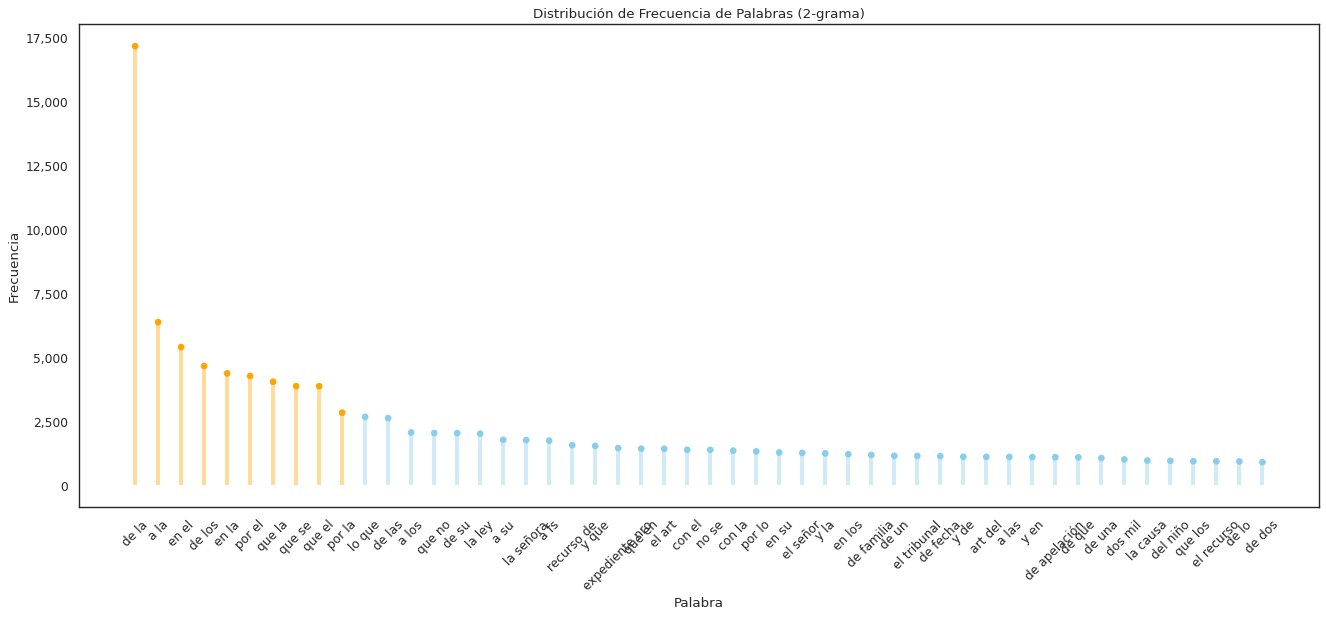

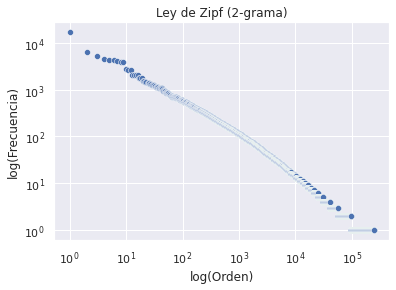

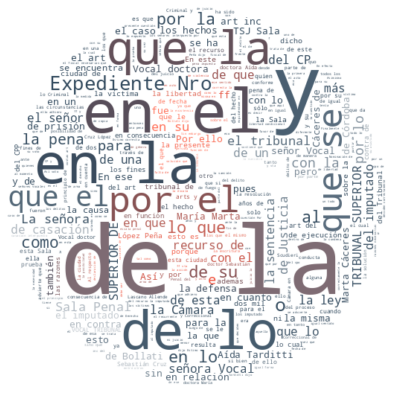

3-grama

Las 50 palabras más frecuentes son:
palabra
de la ley               1438
recurso de apelación     999
por lo que               875
de dos mil               786
art de la                655
a los fines              640
el señor vocal           612
la señora vocal          595
el recurso de            579
por el art               571
los fines de             558
de la causa              536
civil y comercial        532
en el caso               519
la cuota alimentaria     515
el art del               480
que no se                465
en relación a            432
superior de justicia     428
tribunal superior de     427
de la niña               421
código civil y           421
y de la                  415
de la cuota              404
de la nación             397
la suma de               395
de familia de            387
a fin de                 387
que en el                386
a fs se                  384
lo dispuesto por         383
y comercial de           380
en contra de       

/run/user/1000/app/com.jetbrains.PyCharm-Community/ipykernel_334/4102510827.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


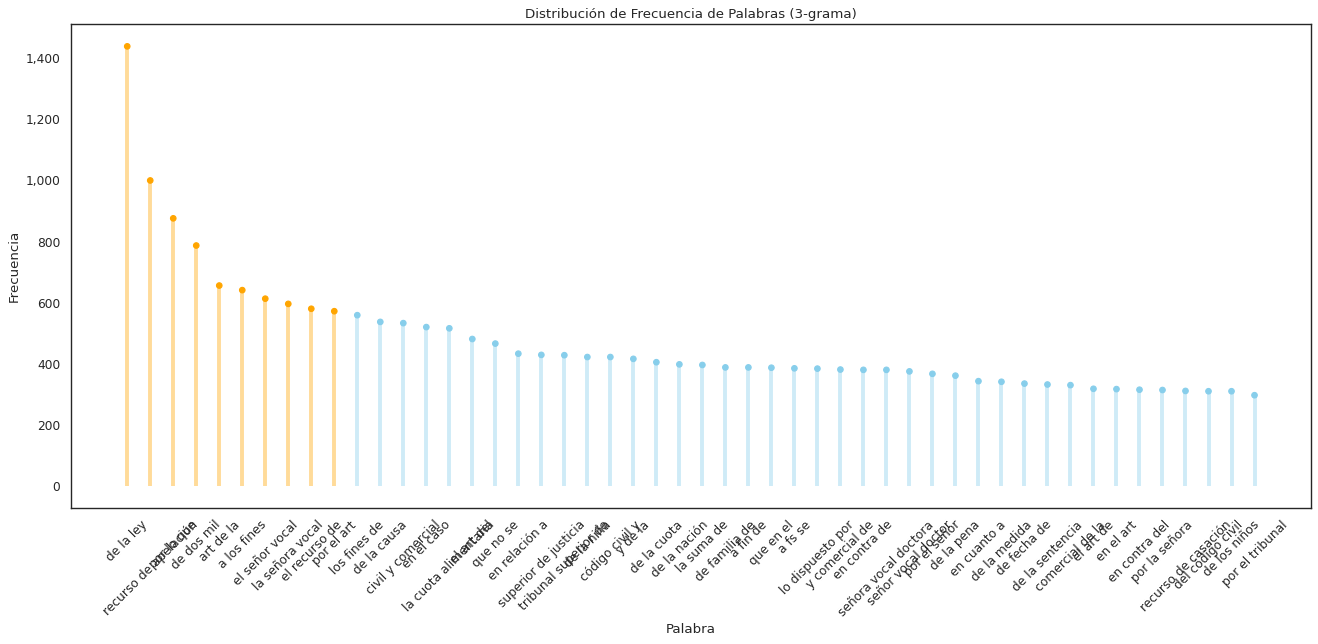

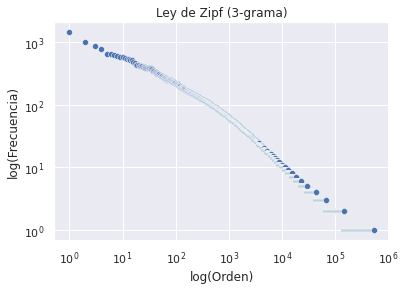

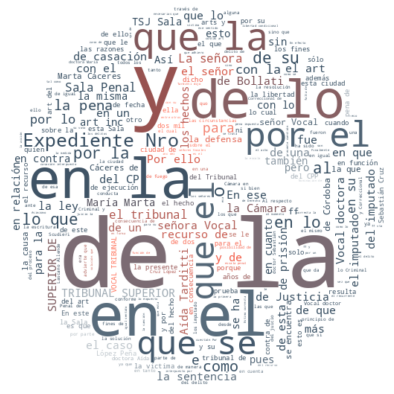

In [40]:
# iteramos por n-gramas de 2 y 3

for n in range(2, 4):
    identifier = f"{n}-grama"
    n_grams = get_n_grams(palabras, n)
    
    ngrams_count = get_conteo_palabras(n_grams)
    
    comparar_frecuencias_palabras(ngrams_count, description=identifier)

    plot_histogram(
        ngrams_count,
        threshold=50,  # Nos quedamos con las 50 palabras más frecuentes
        y_low=None,
        description=identifier)
    
    show_zipf(ngrams_count, description=identifier)
    
    output_name = os.path.join("img", f"{img_name}_wordcloud_{n}-gram.png")

    generar_wordcloud(img_name, STOPWORDS_ES, palabras_fuero, output_name)

##### Elaborar una breve conclusión de lo encontrado

**Analisis de palabras para todos los docs**   
En relación al ejercicio de comparar la palabras más y menos frecuentes se observa que entre las que lideran la categoria de más frecuente se tratan en su mayorías preposiciones, conectores o artículos lo cual tiene sentido ya que en este análisis no existe un preporocesamiento y curación de los datos. Esto torna evidente la necesidad de hacer la limpieza previa de palabras que no aportan a un mejor entendimiento del corpus, sino que por el contrario generan ruido. Sin embargo, igual puede visualziarse algunas palabras vinculadas al mundo legal como ser: tribunal, recurso, fs, ley, familia, parte, autos, expedente, derecho. Por otra parte, entre las palabras menos frecuentes, de las que se pueden observar, en su mayoría no son específicas el ámbito legal por lo que tampoco aportarían demasiado al analisis del dataset, podría concluirse que la curación también debería abarcar casos de poca frecuencía.
Una especie de pre-visualización de cómo un corpus limpio aportaría mayor valor al análisis se observa en la nube de palabras, donde si se optó por eliminar algunas stopword (las más genéricas del idioma español) y en concecuencia se pueden apreciar terminos más asimilables al campo del derecho.

**Analisis de las palabras por fuero.**  
Si el ejercicio de visualizar las palabras con mayor o menor frecuencia se aplica a los documentos que integran el corpus, pero esta vez aplicando una categorización y dividiendolos por fuero, en términos generales los resultados no varían demasiado, al menos para las palabras más frecuentes. Es decir, tanto en el ejercicio anterior como en este, el grupo de palabras que encabeza las más frecuentes siguen siendo conectores, preposiciones, etc. Ahora bien, es interesante que aquí el resto de palabras más frecuentes así como muchas de las menos frecuentes, si están más vinculadas a los fueros judiciales en que se divide el corpus. 
Así, por ejemplo, si se toma el Fuero de Familia, entre las palabras más frecuentes se ven términos específicos de este fuero como "alimentaria" o "cuota", además de otros términos jurídicos más genéricos como: causa, caso, costas, tribunal, etc. Y entre las palabras menos frecuents se ven términos como: divisoria, divorciado, divorciarse. O en el fuero penal, donde entre las palabras más frecuentes y que se podrían entender como específicas de ese ámbito, se ven términos como: pena, vocal, imputado. 
Una conclusión interesante que puede deducirse se este segundo ejercicio es que, en la instancia de preprocesamiento y curación del corpus, tal vez una estrategia que ayude en la limpieza, sea categorizar de alguna forma el corpus. Ello a los fines de poder visualizar mejor los términos que si bien son poco frecuentes tal vez sean muy específicos de esa categoria y no deban eliminarse ya que pueden aportar a un mejor análisis.

*Un punto a destacar, es que en ambos ejercicios, las palabras que más se repiten (tanto en todo el corpus como entre fueros) son preposiciones o artículos. Esto toran evidente que definitivamente es necesario una limpieza para eliminar este tipo de palabras que derivan en ruido para el análisis de los textos.*

**Análisis de los n-gramas**  
Por último, al analizar los resultados obtenidos luego de conformar n-gramas de 2 y 3 palabras, lo que se puede observar es que en el caso de los bi-gramas los que más se repiten son uniones entre porposiciones y artículos, aunque hay algunos casos que podrían entenderse como integrantes del campo jurídico. Ejemplo de estos últimos podrían ser: el tribunal, de apelación, el recurso, la ley, etc. Sin embargo los resultados más interesantes se derivan de los supuestos de tri-gramas donde los grupos de palabras que lideran la categoría de más frecuentes son en su mayoría propias del derecho. Como por ejemplo: de la ley, recurso de apelación, el señor vocal, la señora vocal, civil y comercial, tribunal superior de, etc. De esto podría concluirse que el contexto y las palabras vecines de las que se estén analizando ayudan a determnar el significado de los términos ya que es más probable que ciertos terminos aparecan juntos en determinados textos según el contenido de éstos. 